# Rwondan C02 Emissions: statistics, mapping, and modeling.

## Author Info

Ryan Greene is a data-analyst/data-scientist from the South Jersey / Greater Philadelphia area. He's attended Stockton University to pursue both his undergraduate degree in business and writing, and his masters in data science. He's 28 years old and a big nerd. Ryan is always eager to make new connections and learn more about data analytical and scientific methods.

# Install

Modules we need to install: just folium for the geographical mapping (all the cool kids are doing it!)

In [19]:
# Install module.

!pip install geopandas folium 
# !pip install movingpandas

## Modules

Below we import our modules. We're using numpy and pandas (as always) but additionally pull from sklearn for our machine learning and training and seaborn and matplotlib for graphing and mapping.

Basic settings are set afterwards; I see them often enough that I just copy and paste them by default now.

In [20]:
# Import modules

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score,roc_curve,log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mlxtend.evaluate import bias_variance_decomp
import tensorflow as tf
from sklearn.impute import SimpleImputer

# Leaving this in here: but further down is my attempt at animating the map I was working on.
# from movingpandas import GeoSeriesTimestamp, TrajectoryCollection

# import geopandas as gpd
# import folium
# from folium.plugins import TimestampedGeoJson

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)

We can add in our data and start playing around a little bit now.

# Statistics and Data Exploration

In [43]:
# Variables for our data. Yank those in and then take a quick glance at the data.
# I'm going to just take the head and tail of the training data and slap them together via pd.concat.
# I go about this by instancing my variables for trainingData with Head and Tail respectively.
# From there, I merge the two variables together into one HeadTail since I cannot just do pd.concat(trainingDataHead, trainingDataTail). This throws an error for trying to pass two dataframes together.
# Once they're one variable, you can concat them together. Results below.


trainingData = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
trainingData['ID_LAT_LON_YEAR_WEEK'] = trainingData['ID_LAT_LON_YEAR_WEEK'].astype(str)
trainingDataHead = trainingData.head(10)
trainingDataTail = trainingData.tail(10)
trainingDataHeadTail = [trainingDataHead, trainingDataTail]
trainingDataGlimpse = pd.concat(trainingDataHeadTail)
trainingDataGlimpse

testData = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')
sampleData = pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv')


In [22]:
# Columns so we can get an idea of what we're looking at.
trainingData.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

Based on the above, we've got the various groupings for each row (Sulphur Dioxide, Carbon Monoxide, Nitrogen Dioxide, Formaldehyde, UV Aerosol, as well as the Ozone, UVAersolLayer and Cloud information). It seems to be the particulates, then atmospheric information.

Additionally, there's the a unique key *ID_LAT_LON_YEAR_WEEK*, and the breakdown of that unique key: the latitude, longitude, year, and week number.

We can tell that this data is a *time series*-- which just means taht the data points are indexed over a period of time. I've seen a lot of people do work on this and have the information appear geographically. I don't think I've seen anyone attempt a time-lapse over that map period yet.

In [23]:
# It's always nice to have the basic stats numerically: pandas as .describe for this.
# .describe gves us the mean, standard deviation, minimum, and each of the four quartiles.
# Additionally, I can use .mode() to get the mode; which is just going to be the most common values.
# We create a data frame and add unique values to the data frame by instancing them directly into the data frame: first the basicStats dataframe is created.
# From there with the syntax calling the data frame, then adding the name of that column ('count' for instance), we can then add value to that column directly.
# I played around with the .describe initially but in order to make my own dataframe that's a combination of metrics I want, and the information off describe (which creates a dataframe).

basicStats = pd.DataFrame()
basicStats['unique'] = trainingData.nunique()
basicStats['null'] = trainingData.isnull().sum()
basicStats['dtype'] = trainingData.dtypes
basicStats = pd.concat([basicStats, trainingData.describe().T], axis = 1)
basicStats

unique   null    dtype  \
ID_LAT_LON_YEAR_WEEK                                 79023      0   object   
latitude                                               452      0  float64   
longitude                                              453      0  float64   
year                                                     3      0    int64   
week_no                                                 53      0    int64   
SulphurDioxide_SO2_column_number_density             64409  14609  float64   
SulphurDioxide_SO2_column_number_density_amf         64411  14609  float64   
SulphurDioxide_SO2_slant_column_number_density       64409  14609  float64   
SulphurDioxide_cloud_fraction                        62367  14609  float64   
SulphurDioxide_sensor_azimuth_angle                  64295  14609  float64   
SulphurDioxide_sensor_zenith_angle                   64218  14609  float64   
SulphurDioxide_solar_azimuth_angle                   64377  14609  float64   
SulphurDioxide_solar_zenith_angle                    64376  14609  float64   
SulphurDioxide_SO2_column_number_density_15km        64411  14609  float64   
CarbonMonoxide_CO_column_number_density              76718   2122  float64   
CarbonMonoxide_H2O_column_number_density             76724   2122  float64   
CarbonMonoxide_cloud_height                          76707   2122  float64   
CarbonMonoxide_sensor_altitude                       72994   2122  float64   
CarbonMonoxide_sensor_azimuth_angle                  76596   2122  float64   
CarbonMonoxide_sensor_zenith_angle                   76579   2122  float64   
CarbonMonoxide_solar_azimuth_angle                   76638   2122  float64   
CarbonMonoxide_solar_zenith_angle                    76653   2122  float64   
NitrogenDioxide_NO2_column_number_density            60693  18320  float64   
NitrogenDioxide_tropospheric_NO2_column_number_...   60676  18320  float64   
NitrogenDioxide_stratospheric_NO2_column_number...   60688  18320  float64   
NitrogenDioxide_NO2_slant_column_number_density      60686  18320  float64   
NitrogenDioxide_tropopause_pressure                  56556  18320  float64   
NitrogenDioxide_absorbing_aerosol_index              60693  18320  float64   
NitrogenDioxide_cloud_fraction                       59817  18320  float64   
NitrogenDioxide_sensor_altitude                      55140  18320  float64   
NitrogenDioxide_sensor_azimuth_angle                 60621  18320  float64   
NitrogenDioxide_sensor_zenith_angle                  60581  18320  float64   
NitrogenDioxide_solar_azimuth_angle                  60679  18320  float64   
NitrogenDioxide_solar_zenith_angle                   60681  18320  float64   
Formaldehyde_tropospheric_HCHO_column_number_de...   71733   7277  float64   
Formaldehyde_tropospheric_HCHO_column_number_de...   71734   7277  float64   
Formaldehyde_HCHO_slant_column_number_density        71736   7277  float64   
Formaldehyde_cloud_fraction                          70694   7277  float64   
Formaldehyde_solar_zenith_angle                      71722   7277  float64   
Formaldehyde_solar_azimuth_angle                     71718   7277  float64   
Formaldehyde_sensor_zenith_angle                     71603   7277  float64   
Formaldehyde_sensor_azimuth_angle                    71647   7277  float64   
UvAerosolIndex_absorbing_aerosol_index               78484    539  float64   
UvAerosolIndex_sensor_altitude                       78025    539  float64   
UvAerosolIndex_sensor_azimuth_angle                  78479    539  float64   
UvAerosolIndex_sensor_zenith_angle                   78479    539  float64   
UvAerosolIndex_solar_azimuth_angle                   78480    539  float64   
UvAerosolIndex_solar_zenith_angle                    78481    539  float64   
Ozone_O3_column_number_density                       78475    548  float64   
Ozone_O3_column_number_density_amf                   78475    548  float64   
Ozone_O3_slant_column_number_density                 78475    548  float64

The above data gives us some key insights to the data itself. For instance, the data shown reflects 452-453 points (longitude and latitude aren't equal oddly enough) and the data reflects three years and 53 weeks within those years.

Additionally, while most of the data is very unique, the UVAerosolLayerHeight fields aren't very different. My best guess is this is a telemtric limitation but I don't know a lot of about atmospheric measurements and the tools they use.

# Graphing and Mapping

One of the best ways we can start is a heatmap. By using pandas's correlate function, we can assign values in relation to other values. It excludes NA/null values. We save the correlation of our training data as its own variable, and run it through heatmap. I put in some arguments for taste to try to make it a little more legible, and picked out a color scheme that I like.

/tmp/ipykernel_32/1445941689.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  trainingDataCorr = trainingData.corr()


<Axes: >

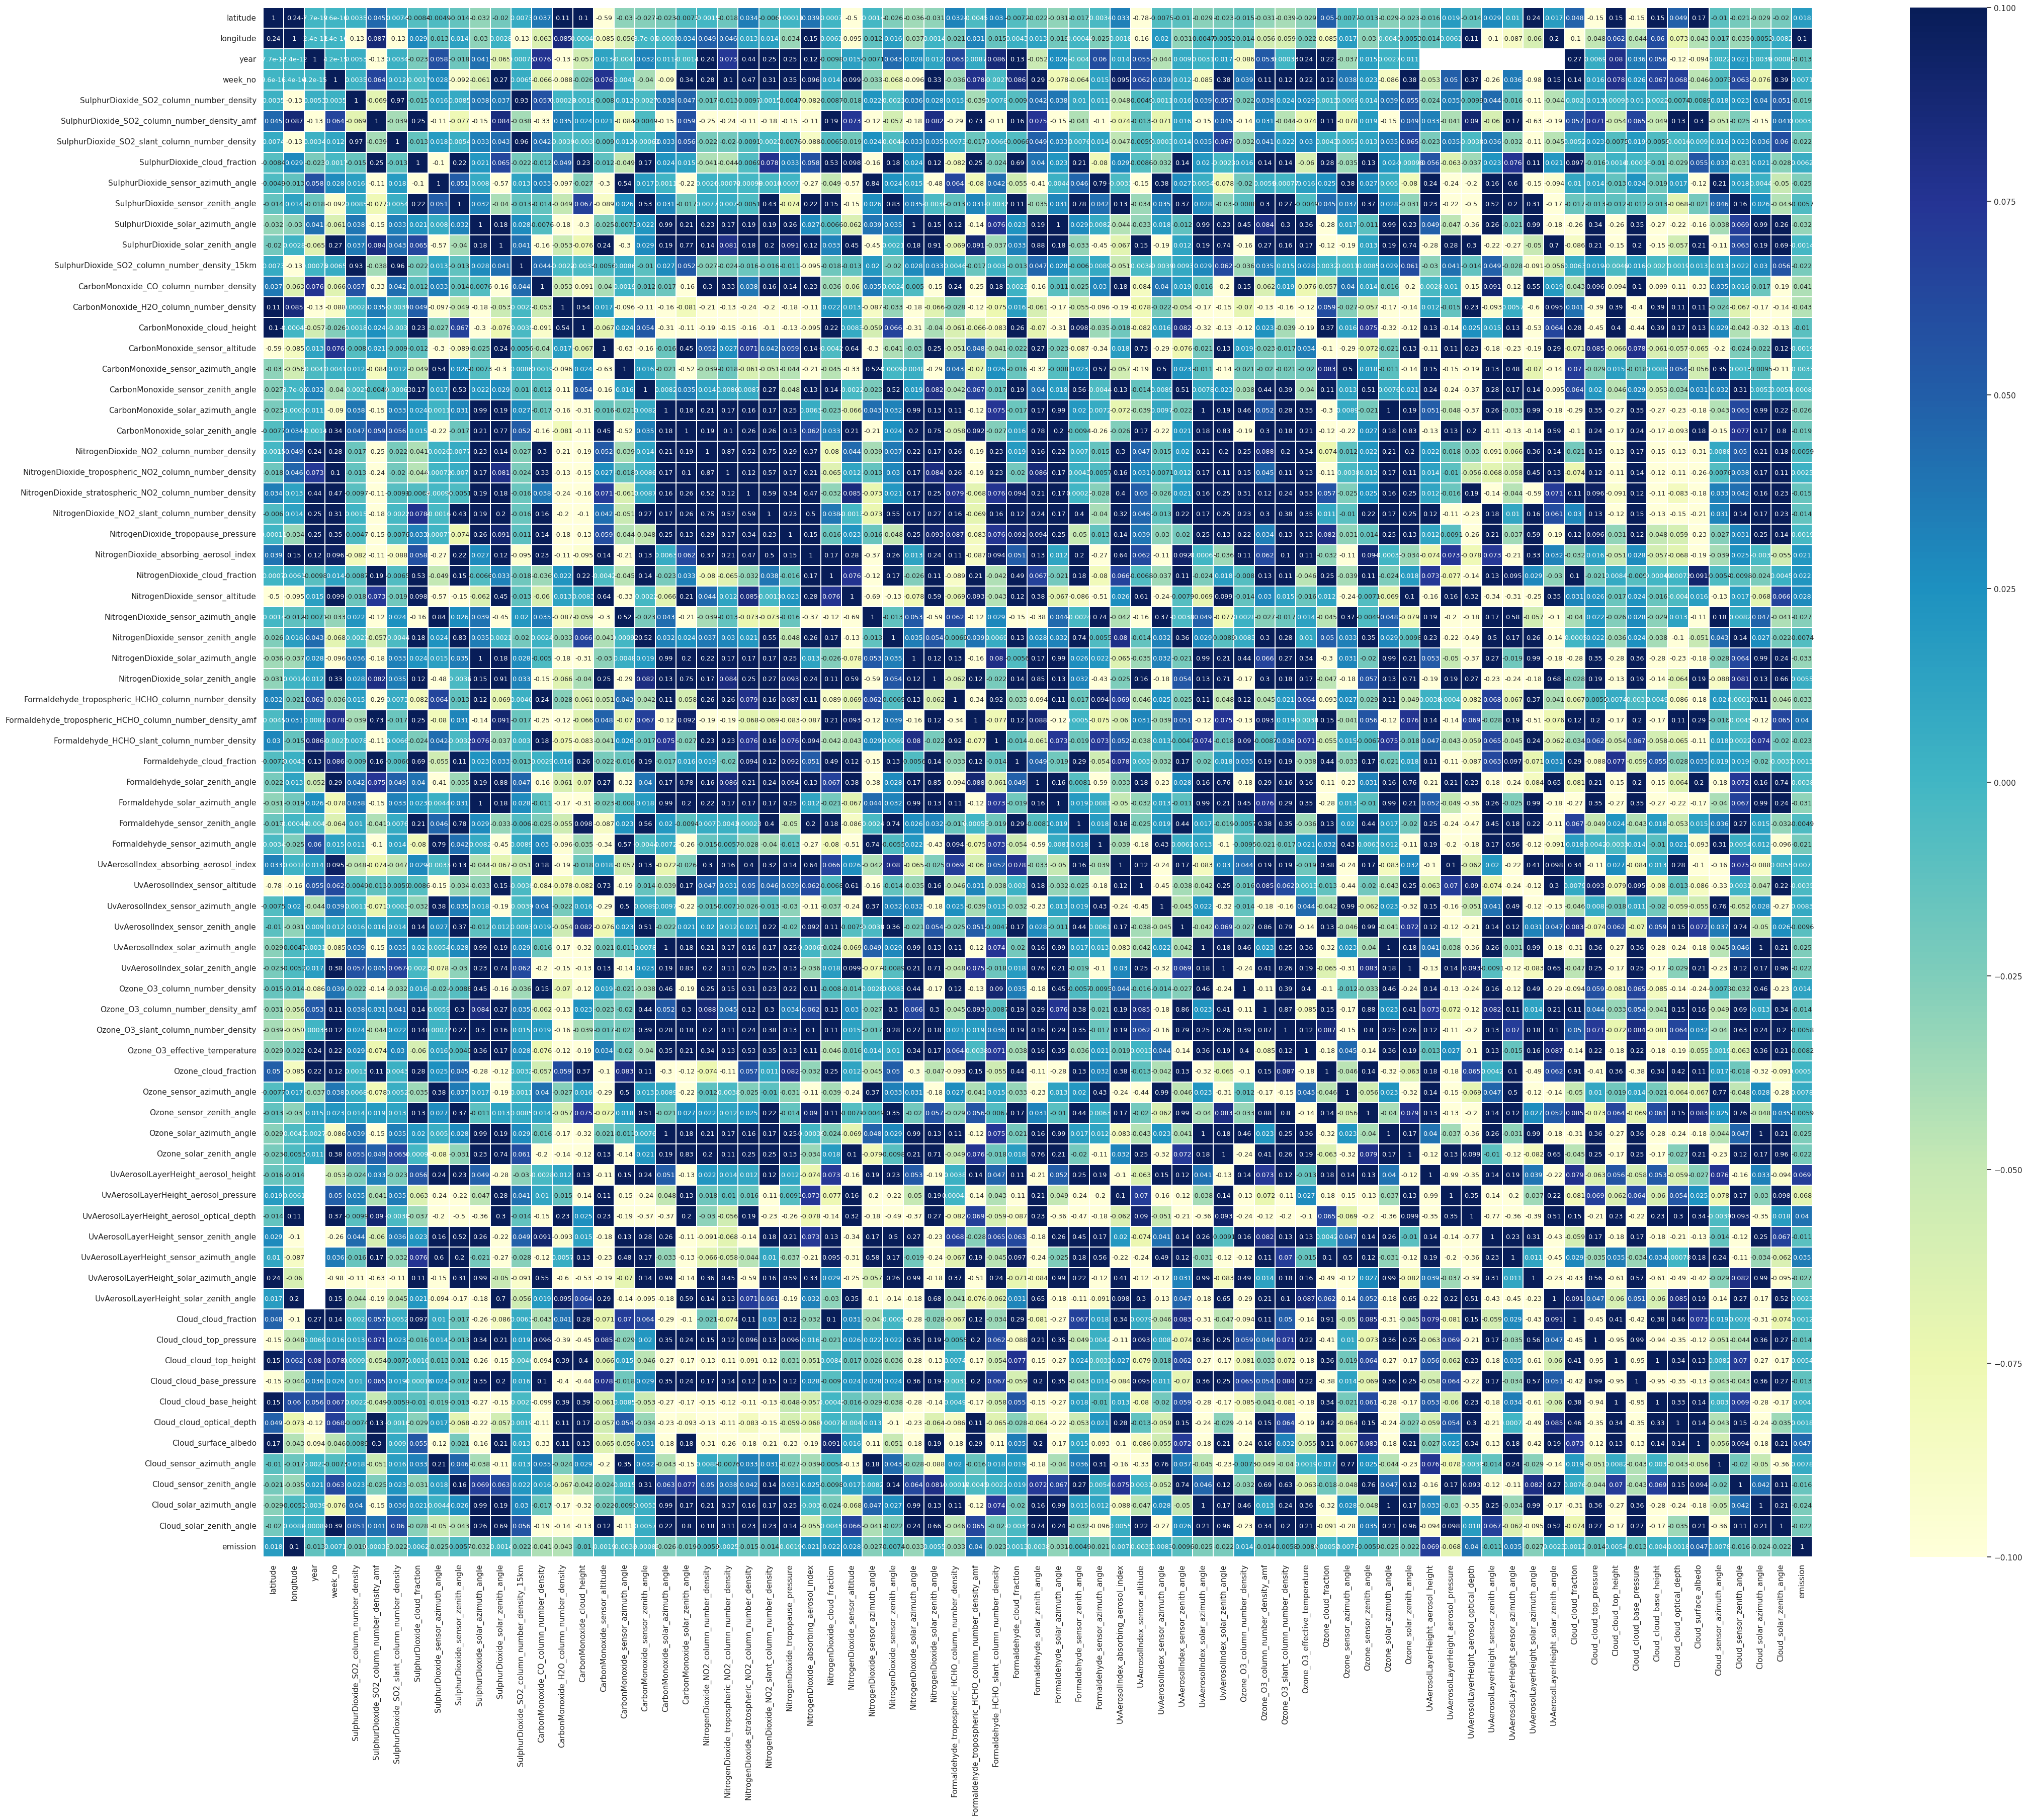

In [24]:
# Save .corr as a variable, run it through seaborn's heatmap.
# Note that for correlative reasons-- a 1 is a positive correlation, a -1 is a negative correlation, and 0 is no correlation. The weight between represents the strength of that correlation until it is either 1 or -1.
# Boxes with a lighter, yellow color have a negative correlation: boxes with a darker, blue color have a positive correlation.

trainingDataCorr = trainingData.corr()
plt.figure(figsize=(50,40))
sns.heatmap(
    trainingDataCorr,
    vmin=trainingDataCorr.values.min(),
    vmax=1,
    square=True,
    cmap="YlGnBu",
    linewidths=0.2,
    annot=True,
    annot_kws={"size": 80 / np.sqrt(len(trainingDataCorr))}
)

## Animated Geological Visualization

As I mentioned above; I've seen people using the geographic data on the sheet (longitude and latitude) to help describe the sheet. I want to combine the geographic data we have and utilize the year and week as well in order to make a geological time series visualization.

### Changing this to Markdown. 

I might've been overly ambitious but I had some code that I thought was closing by converting my dataframe to a Json to a geoJson but that gave me no dice: just an empty map.

Below was my more recent attempt that I had more hope for but movingPandas isn't installing properly for some reason. Leaving this up incase anyone has any suggestions/comments.

### Create a GeoDataFrame from the DataFrame
geometry = gpd.points_from_xy(trainingData.longitude, trainingData.latitude)
geo_df = gpd.GeoDataFrame(trainingData[["latitude", "longitude", "week_no", "year"]], geometry=geometry)

# Convert year and week to datetime
geo_df['date'] = geo_df.apply(lambda row: GeoSeriesTimestamp(f"{row['year']}-W{row['week_no']}-1"), axis=1)

# Create TrajectoryCollection
traj_collection = TrajectoryCollection(geo_df, 'date', 'geometry')

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create the TimestampedGeoJson layer
for traj in traj_collection.trajectories:
    geo_json_data = traj.df.to_json()
    folium.GeoJson(
        geo_json_data,
        name='trajectory',
        show=True,
        style_function=lambda x: {'color': 'red', 'opacity': 0.5},
    ).add_to(all_data_map)

# Fit the map to the bounds of the data
all_data_map.fit_bounds(all_data_map.get_bounds())

# Display the map
all_data_map

# Machine Learning

We've done some fun statistics and graphing but let's move forward towards an actual submission.

First, There's a few things to clean before we actual get our models going. Namely, there's plenty of NaN / null values. We're going to use an imputer to fix those. If the values were so small, we COULD just drop the nulls. We aren't going to do that.

Then, ID_LAT_LON_YEAR_WEEK is an object. It'll cause us issues. We're dropping her like a bad habit.

In [25]:
# Remove object type ID_LAT_LON_YEAR_WEEK
# trainingData.drop("ID_LAT_LON_YEAR_WEEK", axis=1, inplace=True)

494/494 [==============================] - 1s 1ms/step


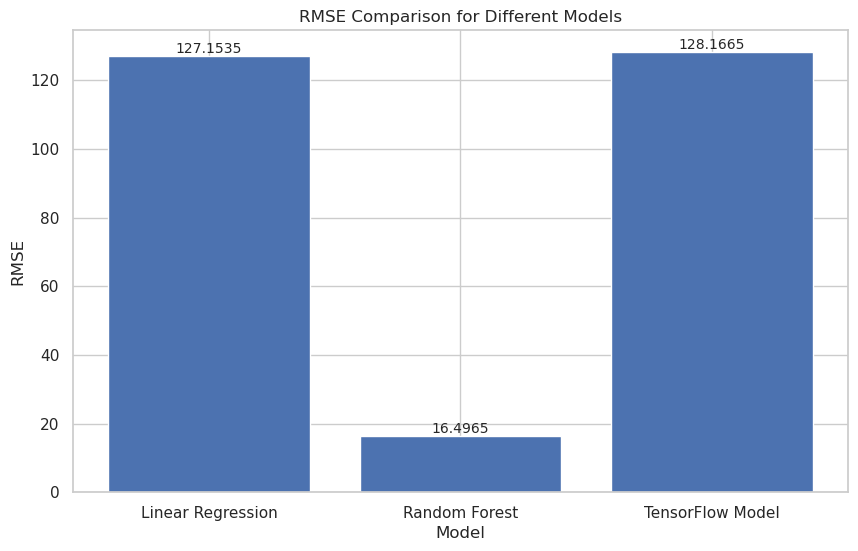

In [26]:
X = trainingData[["latitude", "longitude", "week_no", "year"]]
y = trainingData["emission"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor()

# Train models
linear_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Tensorflow is special: it gets its own model.
def create_tf_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Assuming it's a regression problem
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tf_model = create_tf_model(input_shape=(X_train.shape[1],))
tf_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Make predictions
linear_predictions = linear_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)
tf_predictions = tf_model.predict(X_test)

# Calculate RMSE
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))
random_forest_rmse = np.sqrt(mean_squared_error(y_test, random_forest_predictions))
tf_rmse = np.sqrt(mean_squared_error(y_test, tf_predictions))

# A dictionary to store out RMSE valuews.
rmse_values = {
    'Linear Regression': linear_rmse,
    'Random Forest': random_forest_rmse,
    'TensorFlow Model': tf_rmse
}

# This creates a bar graph so we can graphically see how it's going.
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_values.keys(), rmse_values.values())
plt.title('RMSE Comparison for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')

# Annotations
for x, y in zip(rmse_values.keys(), rmse_values.values()):
    plt.text(x, y, round(y, 4), ha='center', va='bottom', fontsize=10)

plt.show()

## Final Submission

Using our Random Forest model, based on it having the lowest RMSE, we're going to just run the test data through, and call it a day!

In [44]:
# Predict emissions using the Random Forest model
predicted_emissions = random_forest_model.predict(testData[['latitude', 'longitude', 'week_no', 'year']])

# Create a new DataFrame with 'ID_LAT_LON_YEAR_WEEK' and predicted emissions
submission = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': testData['ID_LAT_LON_YEAR_WEEK'],
    'emission': predicted_emissions
})

# Save the DataFrame as a CSV file
submission.to_csv('submission.csv', index=False)

submission

ID_LAT_LON_YEAR_WEEK   emission
0      ID_-0.510_29.290_2022_00   3.454860
1      ID_-0.510_29.290_2022_01   3.787346
2      ID_-0.510_29.290_2022_02   4.025136
3      ID_-0.510_29.290_2022_03   4.064861
4      ID_-0.510_29.290_2022_04   4.170490
...                         ...        ...
24348  ID_-3.299_30.301_2022_44  29.474177
24349  ID_-3.299_30.301_2022_45  29.636829
24350  ID_-3.299_30.301_2022_46  29.687467
24351  ID_-3.299_30.301_2022_47  29.992082
24352  ID_-3.299_30.301_2022_48  29.582191

[24353 rows x 2 columns]